In [1]:
# Load all the functions in the main.py in the GitHub repository

# To run this on your own computer, insert your own GloVe directory into main.py
# by changing the variable "gloveFile"

from main import *

Loading GloVe model
GloVe model loaded successfully


In [39]:
# Import additional libraries used in the machine learning implementation 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

In [13]:
#load the essays dataset

df = pd.read_csv("datasets/essays.csv")

In [14]:
df.head()

,text,filename,text_original,sentence_length,label,text_lemmatized
0,asking students evaluate teachers useful tool ...,104.txt,Asking students to evaluate their teachers can...,15,1,asking student evaluate teacher useful tool im...
1,parents often considered best teachers first r...,3.txt,Parents are often considered the best teachers...,17,1,parent often considered best teacher first rol...
2,many reasons people work beyond need money liv...,50.txt,There are many reasons why people work beyond ...,14,1,many reason people work beyond need money live...
3,success life come combination taking risks car...,53.txt,Success in life can come from a combination of...,15,1,success life come combination taking risk care...
4,attending live performance really enjoyable wa...,36.txt,Attending a live performance is really more en...,28,0,attending live performance really enjoyable wa...


## Evaluating Machine Learning Models

In [9]:
# Create TF-IDF, GloVe and XGBoost based machine learning classifiers.
# Additionally, an ensemble of TF-IDF and XGBoost.

tfidf_transformer = text_to_image_transformer(embedding="tfidf",
                                              algorithm ="SIFTS", 
                                              dimension =1,
                                              sigma =.001,
                                              grid_size= 100)
glove_transformer = text_to_image_transformer(embedding ="glove",
                                              algorithm ="SIF"  , 
                                              dimension =0, 
                                              sigma = .001, 
                                              grid_size = 100)

tfidf_model = Pipeline([("persistence images", tfidf_transformer), 
                        ("classifier",  svm.SVC(probability=True))])

glove_model = Pipeline([("persistence images", glove_transformer), 
                        ("classifier",  svm.SVC(probability=True))])

xgboost_model = Pipeline([('tfidf features', TfidfVectorizer(ngram_range=(1,2),min_df=5)),
                          ('classifier', xgb.XGBClassifier())])

tfidf_xgboost_ensemble = Pipeline([['ensemble', 
                                    VotingClassifier(voting="soft",
                                                     estimators=[("tfidf",tfidf_model), 
                                                               ("xgboost", xgboost_model)])]])

In [16]:
# The training/testing inputs in the pipelines consists of lemmatized texts
X = df["text_lemmatized"].values

# Corresponding labels for each text. 1 for machine-generated and 0 for human-written.
y = df["label"].values

In [18]:
# Make a list of the machine learning models, and their respective names

models = [tfidf_model,
          glove_model,
          xgboost_model,
          tfidf_xgboost_ensemble]

names = ["TF-IDF", "GloVe", "XGBoost", "TF-IDF/XGBoost Ensemble"]

In [12]:
# Evaluate the machine learning models using 5-fold cross valuation
# Prints the test results, average score and standard deviation for each model.

for i in range(len(models)):
    model = models[i]
    name = names[i]
    
    print(name)
    scores = cross_val_score(model, X=X, y=y, cv=5)
    print("Scores:", scores.round(3))
    print('Cross Validation accuracy: %.3f +/- %.3f \n' 
          % (np.mean(scores),np.std(scores)))

TF-IDF
Scores: [0.804 0.863 0.88  0.8   0.88 ]
Cross Validation accuracy: 0.845 +/- 0.036 

GloVe
Scores: [0.863 0.824 0.68  0.82  0.84 ]
Cross Validation accuracy: 0.805 +/- 0.064 

XGBoost
Scores: [0.902 0.941 0.9   0.88  0.92 ]
Cross Validation accuracy: 0.909 +/- 0.021 

TF-IDF/XGBoost Ensemble
Scores: [0.902 0.961 0.94  0.9   0.98 ]
Cross Validation accuracy: 0.937 +/- 0.032 



## Plotting Persistence Images

In [65]:
# Generate the SIFTS TF-IDF persistence images for each document in the dataframe.

persistence_images = tfidf_transformer.fit_transform(X)
df["persistence_image"] = persistence_images.tolist()

# Reformat the flattened 100^2 size arrays (used in machine learning algorithms) 
# to matrices of dimension 100x100 (format of a persistence image of resolution 100x100)
df["persistence_image"] = df["persistence_image"].apply(lambda x: 
                                                        np.array(x).reshape(100,100))

In [70]:
# Create two dataframes consisting of only
# machine-generated and human-written texts respectively.

machine = df[df["label"] == 1].copy()
human = df[df["label"] == 0].copy()

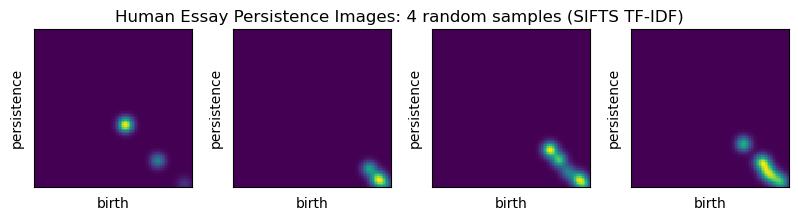

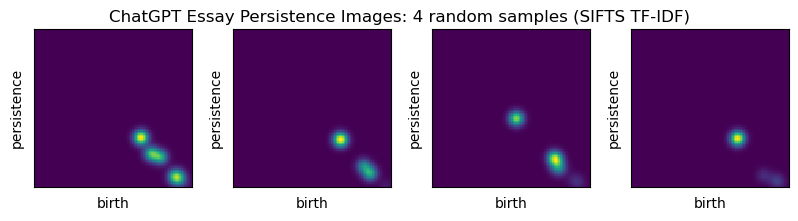

In [83]:
# Plot random samples of persistence images from the human-written and machine-generated essays

datasets = [human,machine]
for i in range(len(datasets)):
    images = datasets[i].sample(4)["persistence_image"].values

    fig, ax = plt.subplots(1,4, figsize =(8,2))
    
    if i == 0:
        plt.suptitle("Human Essay Persistence Images: 4 random samples (SIFTS TF-IDF)")
    else:
        plt.suptitle("ChatGPT Essay Persistence Images: 4 random samples (SIFTS TF-IDF)")
    
    for j in range(len(images)):
        PersistenceImager().plot_image(images[j], ax=ax[j])
    
    plt.tight_layout(pad=0.3)
    plt.show()

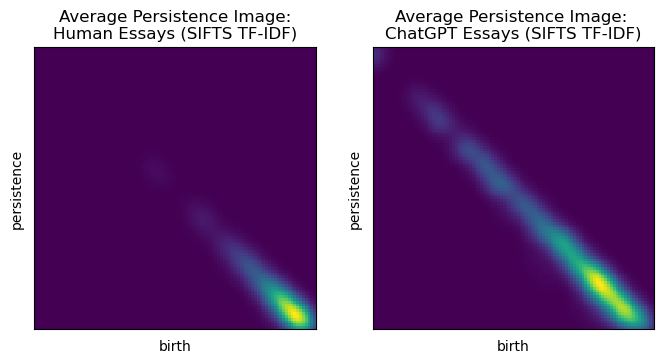

In [77]:
# Plot the average persistence images for the human-written and machine-generated essays

mean_machine = np.mean(machine["persistence_image"].values)
mean_human = np.mean(human["persistence_image"].values)

fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].set_title("Average Persistence Image:\nHuman Essays (SIFTS TF-IDF)")
PersistenceImager().plot_image(mean_human, ax=ax[0])

ax[1].set_title("Average Persistence Image: \nChatGPT Essays (SIFTS TF-IDF)")
PersistenceImager().plot_image(mean_machine, ax=ax[1])

plt.show()

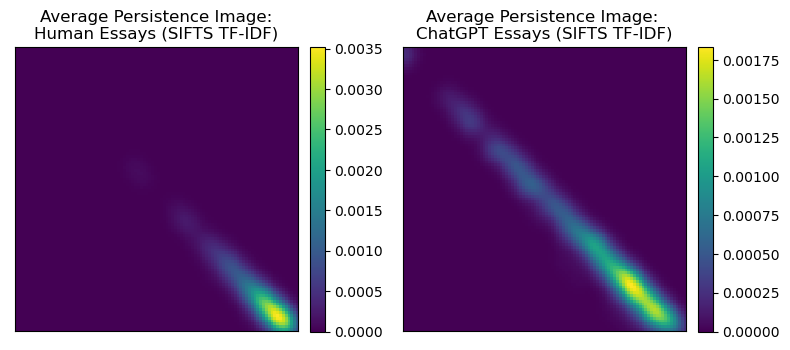

In [82]:
# Alternatively, plotting with imshow in pyplot to also get colorbars
# (as in the figures from the experiment in the master's thesis)

fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].set_title("Average Persistence Image:\nHuman Essays (SIFTS TF-IDF)")
im = ax[0].imshow(np.rot90(mean_human),interpolation="none")
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.colorbar(im,fraction=0.046, pad=0.04,ax=ax[0])

ax[1].set_title("Average Persistence Image: \nChatGPT Essays (SIFTS TF-IDF)")
im = ax[1].imshow(np.rot90(mean_machine),interpolation="none")
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.colorbar(im,fraction=0.046, pad=0.04,ax=ax[1])
plt.tight_layout()
plt.show()         